# Movie Recommender System
Although recommender systems are widely used in modern artificial intelligence, particularly in retail and entertainment industries, many of existing systems in businesses that still use classical methods such as matrix factorisation are found incapable of capturing all of the information now available. One approach to mitigate this issue is to introduce nonlinearity to the system, such as deep nueral network layers in this case, which can improve the performance of recommender systems by both capturing more of the complex patterns of information that are present, and by making it easier to add new information in the form of further data feature columns.

This project uses [TensorFlow Datasets (TFDS)](https://www.tensorflow.org/datasets) and the [TensorFlow Recommenders library (TFRS)](https://www.tensorflow.org/recommenders) to show how the addition of deep learning to a recommender model improves its performance.

## Setup
Let's install TFDS, TFRS, and import these and the Python modules that we need.

In [1]:
!pip install --upgrade pip
!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 55.5 MB/s eta 0:00:00:00:01
  Attempting uninstall: pip
    Found existing installation: pip 22.2.2
    Uninstalling pip-22.2.2:
      Successfully uninstalled pip-22.2.2


In [2]:
import os
import platform
import pprint
import numpy as np
from typing import Dict, Text

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

Print the information about the versions of software that we are using.

In [3]:
print('Numpy version: {}'.format(np.__version__))
print('Python version: {}'.format(platform.python_version()))
print('TensorFlow version: {}'.format(tf.__version__))
print('TensorFlow Datasets version: {}'.format(tfds.__version__))
print('TensorFlow Recommenders version: {}'.format(tfrs.__version__))

Numpy version: 1.23.1
Python version: 3.9.13
TensorFlow version: 2.9.1
TensorFlow Datasets version: 4.7.0
TensorFlow Recommenders version: v0.7.2


See if GPUs are available.

In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2301518706842166398
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 16285958144
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13826206434467118167
physical_device_desc: "device: 0, name: Quadro P5000, pci bus id: 0000:00:05.0, compute capability: 6.1"
xla_global_id: 416903419
]


## Data Preparation
Load the MovieLens data from TensorFlow Datasets.

In [5]:
ratings_raw = tfds.load('movielens/100k-ratings', split='train')

2022-10-26 23:56:45.154445: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/100000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/movielens/100k-ratings/0.1.1.incompleteG2EYRG/movielens-train.tfrecord*...…

Dataset movielens downloaded and prepared to /root/tensorflow_datasets/movielens/100k-ratings/0.1.1. Subsequent calls will reuse this data.


In [6]:
ratings_raw

<PrefetchDataset element_spec={'bucketized_user_age': TensorSpec(shape=(), dtype=tf.float32, name=None), 'movie_genres': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'movie_id': TensorSpec(shape=(), dtype=tf.string, name=None), 'movie_title': TensorSpec(shape=(), dtype=tf.string, name=None), 'raw_user_age': TensorSpec(shape=(), dtype=tf.float32, name=None), 'timestamp': TensorSpec(shape=(), dtype=tf.int64, name=None), 'user_gender': TensorSpec(shape=(), dtype=tf.bool, name=None), 'user_id': TensorSpec(shape=(), dtype=tf.string, name=None), 'user_occupation_label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'user_occupation_text': TensorSpec(shape=(), dtype=tf.string, name=None), 'user_rating': TensorSpec(shape=(), dtype=tf.float32, name=None), 'user_zip_code': TensorSpec(shape=(), dtype=tf.string, name=None)}>

Print the first few rows.

In [7]:
for row in ratings_raw.take(3).as_numpy_iterator():
    pprint.pprint(row)

{'bucketized_user_age': 45.0,
 'movie_genres': array([7]),
 'movie_id': b'357',
 'movie_title': b"One Flew Over the Cuckoo's Nest (1975)",
 'raw_user_age': 46.0,
 'timestamp': 879024327,
 'user_gender': True,
 'user_id': b'138',
 'user_occupation_label': 4,
 'user_occupation_text': b'doctor',
 'user_rating': 4.0,
 'user_zip_code': b'53211'}
{'bucketized_user_age': 25.0,
 'movie_genres': array([ 4, 14]),
 'movie_id': b'709',
 'movie_title': b'Strictly Ballroom (1992)',
 'raw_user_age': 32.0,
 'timestamp': 875654590,
 'user_gender': True,
 'user_id': b'92',
 'user_occupation_label': 5,
 'user_occupation_text': b'entertainment',
 'user_rating': 2.0,
 'user_zip_code': b'80525'}
{'bucketized_user_age': 18.0,
 'movie_genres': array([4]),
 'movie_id': b'412',
 'movie_title': b'Very Brady Sequel, A (1996)',
 'raw_user_age': 24.0,
 'timestamp': 882075110,
 'user_gender': True,
 'user_id': b'301',
 'user_occupation_label': 17,
 'user_occupation_text': b'student',
 'user_rating': 4.0,
 'user_zip_

2022-10-26 23:58:13.507510: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Select the only features we need for training the model.

In [8]:
ratings = ratings_raw.map(lambda x: {
    'movie_title': x['movie_title'],
    'timestamp': x['timestamp'],
    'user_id': x['user_id'],
    'user_rating': x['user_rating']
})

In [9]:
ratings

<MapDataset element_spec={'movie_title': TensorSpec(shape=(), dtype=tf.string, name=None), 'timestamp': TensorSpec(shape=(), dtype=tf.int64, name=None), 'user_id': TensorSpec(shape=(), dtype=tf.string, name=None), 'user_rating': TensorSpec(shape=(), dtype=tf.float32, name=None)}>

Extract the timestamps and create training, validation, and testing sets that do not overlap in time.

In [10]:
timestamps = np.concatenate(list(ratings.map(lambda x: x['timestamp']).batch(100)))

Get minimum and maximum time values.

In [11]:
max_time = timestamps.max()
min_time = timestamps.min()

print('Maximum time value: {}'.format(max_time))
print('Minimum time value: {}'.format(min_time))

Maximum time value: 893286638
Minimum time value: 874724710


Get 60th and 80th percentile times

In [12]:
sixtieth_percentile = min_time + 0.6*(max_time - min_time)
eightieth_percentile = min_time + 0.8*(max_time - min_time)

print('60th percentile time: {}'.format(sixtieth_percentile))
print('80th percentile time: {}'.format(eightieth_percentile))

60th percentile time: 885861866.8
80th percentile time: 889574252.4


Create training, validation, and testing sets

In [13]:
train = ratings.filter(lambda x: x['timestamp'] <= sixtieth_percentile)
validation = ratings.filter(lambda x: x['timestamp'] > sixtieth_percentile and x['timestamp'] <= eightieth_percentile)
test = ratings.filter(lambda x: x['timestamp'] > eightieth_percentile)

We are splitting on time percentiles and not row percentiles, which means that we have assumed the times are roughly evenly distributed.

Check the number of rows in the training, validation, and testing sets is as expected

In [14]:
train_count = 0
validation_count = 0
test_count = 0

for row in train.take(-1).as_numpy_iterator():
    train_count += 1
    
for row in validation.take(-1).as_numpy_iterator():
    validation_count += 1
    
for row in test.take(-1).as_numpy_iterator():
    test_count += 1
    
print('Number of rows in the training set: {}'.format(train_count))
print('Number of rows in the validation set: {}'.format(validation_count))
print('Number of rows in the test set: {}'.format(test_count))
print('Total number of rows: {}'.format(train_count + validation_count + test_count))

Number of rows in the training set: 65336
Number of rows in the validation set: 15778
Number of rows in the test set: 18886
Total number of rows: 100000


Shuffle the data within each data set.

In [15]:
train = train.shuffle(train_count)
validation = validation.shuffle(validation_count)
test = test.shuffle(test_count)

Obtain a list of unique movie titles and user IDs that are needed for the recommender model.

In [19]:
movie_titles = ratings.batch(1_000_000).map(lambda x: x['movie_title'])
user_ids = ratings.batch(1_000_000).map(lambda x: x['user_id'])

In [20]:
unique_movie_titles = np.unique(np.concatenate(list(movie_titles)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))

## Recommender Models
To reduce the chance of errors being introduced when it is deployed in production, some of the feature engineering layers are incorporated as part of the model. The model is described by a Python class that inherits from the TFRS base class. The class will include:
* Embeddings for movie titles
* Embeddings for user ids
* Some dense layers to compute the rankings
* TFRS task layer to compute mean squared error
* The `call()` method
* The `compute_loss()` method

### Basic Ranking Model
This model shows what happens when a model is set up with some default parameters, without attempting to tune any of them.

In [33]:
class ModelBasicRanking(tfrs.models.Model):
    
    def __init__(self) -> None:
        super().__init__()
        embedding_dimension = 32
        
        self.movie_model: tf.keras.layers.Layer = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=unique_movie_titles, mask_token=None),
            tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
        ])
        
        self.user_model: tf.keras.layers.Layer = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=unique_user_ids, mask_token=None),
            tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
        ])
        
        self.rating_model = tf.keras.Sequential([
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(1)
        ])
        
        self.task : tf.keras.layers.Layer = tfrs.tasks.Ranking(
            loss=tf.keras.losses.MeanSquaredError(),
            metrics=[tf.keras.metrics.RootMeanSquaredError()]
        )
    
    def call(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:
        user_embeddings = self.user_model(features['user_id'])
        movie_embeddings = self.movie_model(features['movie_title'])
        rating_model = self.rating_model(tf.concat([user_embeddings, movie_embeddings], axis=1))
        
        return (user_embeddings,
                movie_embeddings,
                rating_model)
    
    def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
        ratings = features.pop('user_rating')
        user_embeddings, movie_embeddings, rating_predictions = self(features)
        
        rating_loss = self.task(
            labels=ratings,
            predictions=rating_predictions
        )
        
        return rating_loss

Print out some training examples.

In [34]:
train

<ShuffleDataset element_spec={'movie_title': TensorSpec(shape=(), dtype=tf.string, name=None), 'timestamp': TensorSpec(shape=(), dtype=tf.int64, name=None), 'user_id': TensorSpec(shape=(), dtype=tf.string, name=None), 'user_rating': TensorSpec(shape=(), dtype=tf.float32, name=None)}>

In [35]:
for x in train.take(3).as_numpy_iterator():
    pprint.pprint(x)

{'movie_title': b'Forrest Gump (1994)',
 'timestamp': 879435628,
 'user_id': b'419',
 'user_rating': 4.0}
{'movie_title': b'Gandhi (1982)',
 'timestamp': 875239018,
 'user_id': b'297',
 'user_rating': 5.0}
{'movie_title': b'Apocalypse Now (1979)',
 'timestamp': 882141248,
 'user_id': b'13',
 'user_rating': 5.0}


Reshuffle the training and validation sets. Then batch and cache all three data
sets.

In [36]:
train_batch_size = 8192
test_batch_size = 4096

cached_train = train.shuffle(train_count).batch(train_batch_size).cache()
cached_validation = validation.shuffle(validation_count).batch(train_batch_size).cache()
cached_test = test.batch(test_batch_size).cache()

The data is now a `CacheDataset`.

In [37]:
cached_train

<CacheDataset element_spec={'movie_title': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'timestamp': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'user_id': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'user_rating': TensorSpec(shape=(None,), dtype=tf.float32, name=None)}>

In [38]:
for x in cached_train.take(3).as_numpy_iterator():
    pprint.pprint(x)

{'movie_title': array([b'Super Mario Bros. (1993)', b'Birdcage, The (1996)',
       b'Professional, The (1994)', ..., b'Ref, The (1994)',
       b'Tombstone (1993)', b'Grifters, The (1990)'], dtype=object),
 'timestamp': array([875636167, 876402814, 877636713, ..., 883364433, 883949200,
       884111485]),
 'user_id': array([b'5', b'343', b'162', ..., b'476', b'846', b'201'], dtype=object),
 'user_rating': array([2., 2., 3., ..., 2., 5., 4.], dtype=float32)}
{'movie_title': array([b'Full Metal Jacket (1987)', b'Wizard of Oz, The (1939)',
       b'Three Colors: White (1994)', ..., b'Washington Square (1997)',
       b'Pretty Woman (1990)', b'Leaving Las Vegas (1995)'], dtype=object),
 'timestamp': array([883767325, 884753028, 874730031, ..., 878962006, 880143243,
       880485573]),
 'user_id': array([b'508', b'77', b'712', ..., b'181', b'437', b'230'], dtype=object),
 'user_rating': array([4., 3., 3., ..., 1., 3., 5.], dtype=float32)}
{'movie_title': array([b'Kull the Conqueror (1997)'

2022-10-27 01:00:49.687770: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


#### Model Training
Train the basic ranking model for a few epochs and output the accuracy on the training set and also on the validation set.

In [39]:
model_br = ModelBasicRanking()
model_br.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

In [40]:
history_br = model_br.fit(cached_train, epochs=3, validation_data=cached_validation)

Epoch 1/3
8/8 [==============================] - 19s 1s/step - root_mean_squared_error: 2.5269 - loss: 5.8033 - regularization_loss: 0.0000e+00 - total_loss: 5.8033 - val_root_mean_squared_error: 1.1370 - val_loss: 1.2956 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.2956
Epoch 2/3
8/8 [==============================] - 0s 6ms/step - root_mean_squared_error: 1.1187 - loss: 1.2505 - regularization_loss: 0.0000e+00 - total_loss: 1.2505 - val_root_mean_squared_error: 1.1401 - val_loss: 1.3050 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.3050
Epoch 3/3
8/8 [==============================] - 0s 6ms/step - root_mean_squared_error: 1.1081 - loss: 1.2265 - regularization_loss: 0.0000e+00 - total_loss: 1.2265 - val_root_mean_squared_error: 1.1391 - val_loss: 1.3031 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.3031


In [41]:
pprint.pprint(history_br.history)

{'loss': [1.2727948427200317, 1.2426050901412964, 1.2152608633041382],
 'regularization_loss': [0, 0, 0],
 'root_mean_squared_error': [2.5268912315368652,
                             1.1187320947647095,
                             1.1081016063690186],
 'total_loss': [1.2727948427200317, 1.2426050901412964, 1.2152608633041382],
 'val_loss': [1.2956467866897583, 1.3050323724746704, 1.303053379058838],
 'val_regularization_loss': [0, 0, 0],
 'val_root_mean_squared_error': [1.1369529962539673,
                                 1.140109896659851,
                                 1.1390788555145264],
 'val_total_loss': [1.2956467866897583, 1.3050323724746704, 1.303053379058838]}


The model has a performance of root mean squared error (RMSE) between predicted and true user ratings of movies of about 1.1, and the value is similar for training and validation, indicating that with the short training duration here the model has not overfit.

In [52]:
rsme_br = history_br.history['root_mean_squared_error'][-1]
val_rsme_br = history_br.history['val_root_mean_squared_error'][-1]

print('Training RSME: {:.2f}'.format(rsme_br))
print('Validation RSME: {:.2f}'.format(val_rsme_br))

Training RSME: 1.11
Validation RSME: 1.14


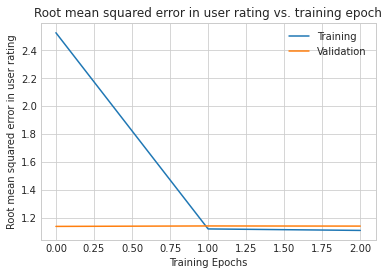

In [43]:
num_validation_runs = len(history_br.history['val_root_mean_squared_error'])
validation_freq = 1
epochs = [(x + 1) * validation_freq for x in range(num_validation_runs)]

plt.plot(history_br.history['root_mean_squared_error'], label='Training')
plt.plot(history_br.history['val_root_mean_squared_error'], label='Validation')
plt.title('Root mean squared error in user rating vs. training epoch')
plt.xlabel('Training Epochs')
plt.ylabel('Root mean squared error in user rating')
plt.legend()

Inspect the model architecture via `Model.summary()`.

In [44]:
model_br.summary()

Model: "model_basic_ranking_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (None, 32)                53280     
                                                                 
 sequential_7 (Sequential)   (None, 32)                30208     
                                                                 
 sequential_8 (Sequential)   (None, 1)                 33153     
                                                                 
 ranking_2 (Ranking)         multiple                  0         
                                                                 
Total params: 116,641
Trainable params: 116,641
Non-trainable params: 0
_________________________________________________________________


#### Model Evaluation
Evaluate the trained model agaist the cached test dataset.

In [45]:
evaluation_br = model_br.evaluate(cached_test, return_dict=True)

5/5 [==============================] - 7s 19ms/step - root_mean_squared_error: 1.1141 - loss: 1.2387 - regularization_loss: 0.0000e+00 - total_loss: 1.2387


In [48]:
evaluation_br

{'root_mean_squared_error': 1.11407470703125,
 'loss': 1.2303677797317505,
 'regularization_loss': 0,
 'total_loss': 1.2303677797317505}

In [51]:
rsme_eval_br = evaluation_br['root_mean_squared_error']

print('Evaluation RSME: {:.2f}'.format(rsme_eval_br))

Evaluation RSME: 1.11


Inspect the output when calling `predict()` on the model. As written, the model prediction returns both the embeddings and predicted ratings.

In [53]:
model_br.predict(cached_test)

5/5 [==============================] - 0s 7ms/step


(array([[ 0.01245945,  0.01495936, -0.01818842, ...,  0.04419737,
          0.021081  , -0.03585839],
        [ 0.02808915, -0.04886239, -0.03236403, ..., -0.04018389,
          0.00144045, -0.01762201],
        [ 0.01965872, -0.04033671, -0.02286918, ..., -0.02471747,
          0.04037458,  0.02035589],
        ...,
        [ 0.00980061,  0.01124493,  0.01731365, ..., -0.03023567,
          0.01569464,  0.01913308],
        [ 0.03816751, -0.00214174, -0.02067989, ...,  0.03537724,
         -0.03579115, -0.04890109],
        [ 0.00534248, -0.03150116,  0.03796741, ...,  0.01551921,
         -0.0421725 ,  0.01977516]], dtype=float32),
 array([[ 9.7947046e-03,  2.3573948e-02, -3.6175787e-02, ...,
          4.0159959e-02,  2.0572212e-02,  3.0795708e-02],
        [-3.7286791e-03,  4.7210958e-02, -4.5613155e-02, ...,
         -8.3289240e-03, -1.7311914e-02, -3.3461288e-02],
        [ 8.7674816e-06, -2.2235097e-02, -1.5709866e-02, ...,
          2.4766916e-02,  1.6739096e-02, -3.8537495e-02]

### Tuned Ranking Model
For this model, we perform some basic tuning on the neural network layer by training it for more epochs and allowing its initial learning rate to vary. We also add regularisation to help avoid overfitting that could result from longer training.

In [54]:
class ModelTunedRanking(tfrs.models.Model):
    
    def __init__(self) -> None:
        super().__init__()
        embedding_dimension = 32
        
        self.movie_model: tf.keras.layers.Layer = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=unique_movie_titles, mask_token=None),
            tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
        ])
        
        self.user_model: tf.keras.layers.Layer = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=unique_user_ids, mask_token=None),
            tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
        ])
        
        self.rating_model = tf.keras.Sequential([
            tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
            tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
            tf.keras.layers.Dense(1)
        ])
        
        self.task : tf.keras.layers.Layer = tfrs.tasks.Ranking(
            loss=tf.keras.losses.MeanSquaredError(),
            metrics=[tf.keras.metrics.RootMeanSquaredError()]
        )
    
    def call(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:
        user_embeddings = self.user_model(features['user_id'])
        movie_embeddings = self.movie_model(features['movie_title'])
        rating_model = self.rating_model(tf.concat([user_embeddings, movie_embeddings], axis=1))
        
        return (user_embeddings,
                movie_embeddings,
                rating_model)
    
    def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
        ratings = features.pop('user_rating')
        user_embeddings, movie_embeddings, rating_predictions = self(features)
        
        rating_loss = self.task(
            labels=ratings,
            predictions=rating_predictions
        )
        
        return rating_loss

#### Model Training
List some learning rates in the logarithmic scale and the number of epochs.

In [55]:
learning_rate_logarithmic = [0.001, 0.01, 0.1, 1]
epochs = 30

Run the logarithmic grid.

In [56]:
histories_tr = {}

for learning_rate in learning_rate_logarithmic:
    print('Learning rate: {}'.format(learning_rate))
    model_tr = ModelTunedRanking()
    model_tr.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=learning_rate))
    
    lr = str(learning_rate)
    histories_tr[lr] = model_tr.fit(cached_train, epochs=epochs, validation_data=cached_validation)

Learning rate: 0.001
Epoch 1/30
8/8 [==============================] - 1s 24ms/step - root_mean_squared_error: 3.6928 - loss: 13.6225 - regularization_loss: 2.0484 - total_loss: 15.6709 - val_root_mean_squared_error: 3.5886 - val_loss: 12.7858 - val_regularization_loss: 2.0473 - val_total_loss: 14.8331
Epoch 2/30
8/8 [==============================] - 0s 6ms/step - root_mean_squared_error: 3.6601 - loss: 13.3866 - regularization_loss: 2.0463 - total_loss: 15.4329 - val_root_mean_squared_error: 3.5615 - val_loss: 12.5929 - val_regularization_loss: 2.0453 - val_total_loss: 14.6382
Epoch 3/30
8/8 [==============================] - 0s 6ms/step - root_mean_squared_error: 3.6348 - loss: 13.2032 - regularization_loss: 2.0444 - total_loss: 15.2476 - val_root_mean_squared_error: 3.5378 - val_loss: 12.4258 - val_regularization_loss: 2.0434 - val_total_loss: 14.4692
Epoch 4/30
8/8 [==============================] - 0s 8ms/step - root_mean_squared_error: 3.6120 - loss: 13.0383 - regularization_los

In [57]:
histories_tr

{'0.001': <keras.callbacks.History at 0x7f93f5423130>,
 '0.01': <keras.callbacks.History at 0x7f93f57ee1f0>,
 '0.1': <keras.callbacks.History at 0x7f93f5392760>,
 '1': <keras.callbacks.History at 0x7f93f567f790>}

Print the history for the learning rate of 0.1

In [58]:
pprint.pprint(histories_tr['0.1'].history, compact=True)

{'loss': [1.3927000761032104, 1.2683188915252686, 1.2422082424163818,
          1.2181053161621094, 1.1890560388565063, 1.1570007801055908,
          1.1264005899429321, 1.098044991493225, 1.0719166994094849,
          1.048281192779541, 1.0277040004730225, 1.0102273225784302,
          0.9948394894599915, 0.9806035757064819, 0.9673331379890442,
          0.9554618000984192, 0.94521564245224, 0.9365049600601196,
          0.9289951324462891, 0.9224698543548584, 0.9167397022247314,
          0.9116432070732117, 0.9070450663566589, 0.9028892517089844,
          0.8991394639015198, 0.8957191705703735, 0.8926036357879639,
          0.8897396922111511, 0.8871327638626099, 0.8847389221191406],
 'regularization_loss': [1.888035535812378, 1.7109789848327637,
                         1.5503778457641602, 1.406064510345459,
                         1.276890516281128, 1.1613895893096924,
                         1.0577499866485596, 0.9645450115203857,
                         0.8806756734848022, 0

In [61]:
for learning_rate in learning_rate_logarithmic:
    lr = str(learning_rate)
    rsme_tr = histories_tr[lr].history['root_mean_squared_error'][-1]
    rsme_val_tr = histories_tr[lr].history['val_root_mean_squared_error'][-1]
    
    print('Training RSME with learning rate {}: {:.2f}'.format(lr, rsme_tr))
    print('Validation RSME with learning rate {}: {:.2f}'.format(lr, rsme_val_tr))

Training RSME with learning rate 0.001: 2.97
Validation RSME with learning rate 0.001: 2.88
Training RSME with learning rate 0.01: 1.08
Validation RSME with learning rate 0.01: 1.12
Training RSME with learning rate 0.1: 0.93
Validation RSME with learning rate 0.1: 1.06
Training RSME with learning rate 1: 3.02
Validation RSME with learning rate 1: 2.92


In [64]:
num_validation_runs = len(histories_tr['0.1'].history['val_root_mean_squared_error'])
validation_freq = 1
epochs_x = [(x + 1) * validation_freq for x in range(num_validation_runs)]

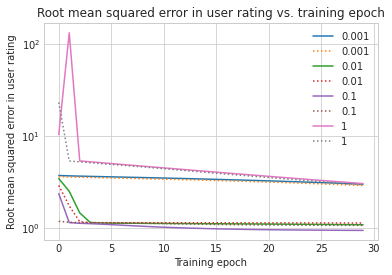

In [81]:
for learning_rate in learning_rate_logarithmic:
    lr = str(learning_rate)
    plt.plot(histories_tr[lr].history['root_mean_squared_error'], label=lr)
    plt.plot(histories_tr[lr].history['val_root_mean_squared_error'], label=lr, linestyle='dotted')
    
plt.title('Root mean squared error in user rating vs. training epoch')
plt.xlabel('Training epoch')
plt.ylabel('Root mean squared error in user rating')
plt.yscale('log')
plt.legend()

It looks like learning rates closer in magnitude to 0.1 are best.

Run the linear grid.

In [67]:
histories_tr_li = {}
learning_rates_linear = [0.05, 0.1, 0.15]
epochs = 30

for learning_rate in learning_rates_linear:
    print('Learning rate: {}'.format(learning_rate))
    model_tr = ModelTunedRanking()
    model_tr.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=learning_rate))
    
    lr = str(learning_rate)
    histories_tr_li[lr] = model_tr.fit(cached_train, epochs=epochs, validation_data=cached_validation)

Learning rate: 0.05
Epoch 1/30
8/8 [==============================] - 1s 26ms/step - root_mean_squared_error: 2.1879 - loss: 4.3916 - regularization_loss: 2.0106 - total_loss: 6.4022 - val_root_mean_squared_error: 1.1553 - val_loss: 1.3415 - val_regularization_loss: 1.9685 - val_total_loss: 3.3099
Epoch 2/30
8/8 [==============================] - 0s 5ms/step - root_mean_squared_error: 1.1269 - loss: 1.2692 - regularization_loss: 1.9201 - total_loss: 3.1893 - val_root_mean_squared_error: 1.1390 - val_loss: 1.3019 - val_regularization_loss: 1.8717 - val_total_loss: 3.1735
Epoch 3/30
8/8 [==============================] - 0s 6ms/step - root_mean_squared_error: 1.1187 - loss: 1.2515 - regularization_loss: 1.8265 - total_loss: 3.0781 - val_root_mean_squared_error: 1.1367 - val_loss: 1.2963 - val_regularization_loss: 1.7806 - val_total_loss: 3.0769
Epoch 4/30
8/8 [==============================] - 0s 6ms/step - root_mean_squared_error: 1.1139 - loss: 1.2409 - regularization_loss: 1.7380 - to

In [68]:
histories_tr_li

{'0.05': <keras.callbacks.History at 0x7f93ec2f0130>,
 '0.1': <keras.callbacks.History at 0x7f93ec1a5640>,
 '0.15': <keras.callbacks.History at 0x7f93ec076af0>}

In [70]:
for learning_rate in learning_rates_linear:
    lr = str(learning_rate)
    rsme_tr = histories_tr_li[lr].history['root_mean_squared_error'][-1]
    rsme_val_tr = histories_tr_li[lr].history['val_root_mean_squared_error'][-1]
    
    print('Training RSME with learning rate {}: {:.2f}'.format(lr, rsme_tr))
    print('Validation RSME with learning rate {}: {:.2f}'.format(lr, rsme_val_tr))

Training RSME with learning rate 0.05: 0.95
Validation RSME with learning rate 0.05: 1.07
Training RSME with learning rate 0.1: 0.94
Validation RSME with learning rate 0.1: 1.06
Training RSME with learning rate 0.15: 0.93
Validation RSME with learning rate 0.15: 1.06


In [71]:
num_validation_runs = len(histories_tr_li['0.1'].history['val_root_mean_squared_error'])
validation_freq = 1
epochs_x = [(x + 1) * validation_freq for x in range(num_validation_runs)]

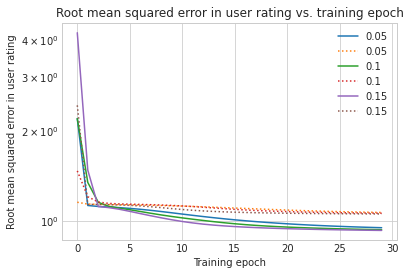

In [80]:
for learning_rate in learning_rates_linear:
    lr = str(learning_rate)
    plt.plot(histories_tr_li[lr].history['root_mean_squared_error'], label=lr)
    plt.plot(histories_tr_li[lr].history['val_root_mean_squared_error'], label=lr, linestyle='dotted')
    
plt.title('Root mean squared error in user rating vs. training epoch')
plt.xlabel('Training epoch')
plt.ylabel('Root mean squared error in user rating')
plt.yscale('log')
plt.legend()

The best performances for the linear grid search look quite similar to each other, so let's stick with learning rate 0.1 and train the final model.

In [74]:
epochs = 50

model_tr = ModelTunedRanking()
model_tr.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))
history_tr = model_tr.fit(cached_train, epochs=epochs, validation_data=cached_validation)

Epoch 1/50
8/8 [==============================] - 1s 27ms/step - root_mean_squared_error: 2.4773 - loss: 5.6850 - regularization_loss: 1.9573 - total_loss: 7.6424 - val_root_mean_squared_error: 1.1413 - val_loss: 1.3087 - val_regularization_loss: 1.8716 - val_total_loss: 3.1803
Epoch 2/50
8/8 [==============================] - 0s 6ms/step - root_mean_squared_error: 1.1232 - loss: 1.2615 - regularization_loss: 1.7836 - total_loss: 3.0450 - val_root_mean_squared_error: 1.1362 - val_loss: 1.2961 - val_regularization_loss: 1.6944 - val_total_loss: 2.9905
Epoch 3/50
8/8 [==============================] - 0s 6ms/step - root_mean_squared_error: 1.1181 - loss: 1.2501 - regularization_loss: 1.6155 - total_loss: 2.8655 - val_root_mean_squared_error: 1.1351 - val_loss: 1.2939 - val_regularization_loss: 1.5352 - val_total_loss: 2.8291
Epoch 4/50
8/8 [==============================] - 0s 6ms/step - root_mean_squared_error: 1.1121 - loss: 1.2366 - regularization_loss: 1.4642 - total_loss: 2.7008 - v

In [75]:
rsme_tr = history_tr.history['root_mean_squared_error'][-1]
rsme_val_tr = history_tr.history['val_root_mean_squared_error'][-1]

print('Training RSME: {:.2f}'.format(rsme_tr))
print('Validation RSME: {:.2f}'.format(rsme_val_tr))

Training RSME: 0.92
Validation RSME: 1.05


In [77]:
num_validation_runs = len(history_tr.history['val_root_mean_squared_error'])
validation_freq = 1
epochs_x = [(x + 1) * validation_freq for x in range(num_validation_runs)]

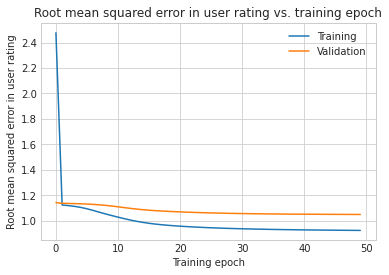

In [79]:
plt.plot(history_tr.history['root_mean_squared_error'], label='Training')
plt.plot(history_tr.history['val_root_mean_squared_error'], label='Validation')
plt.title('Root mean squared error in user rating vs. training epoch')
plt.xlabel('Training epoch')
plt.ylabel('Root mean squared error in user rating')
plt.legend()

See the summary of the final model architecture.

In [82]:
model_tr.summary()

Model: "model_tuned_ranking_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_36 (Sequential)  (None, 32)                53280     
                                                                 
 sequential_37 (Sequential)  (None, 32)                30208     
                                                                 
 sequential_38 (Sequential)  (None, 1)                 33153     
                                                                 
 ranking_12 (Ranking)        multiple                  0         
                                                                 
Total params: 116,641
Trainable params: 116,641
Non-trainable params: 0
_________________________________________________________________


#### Model Evaluation
As with the basic model, the performance of the model on the unseen testing data is similar to the validation performance, at about RMSE ~ 1.

In [83]:
evaluation_tr = model_tr.evaluate(cached_test, return_dict=True)

5/5 [==============================] - 0s 9ms/step - root_mean_squared_error: 1.0334 - loss: 1.0646 - regularization_loss: 0.0767 - total_loss: 1.1414


In [84]:
rsme_eval = evaluation_tr['root_mean_squared_error']
print('Evaluation RSME: {:.2f}'.format(rsme_eval))

Evaluation RSME: 1.03


New data can now be sent to the model.

In [85]:
model_tr.predict(cached_test)

5/5 [==============================] - 0s 8ms/step


(array([[-0.00103073, -0.00880963, -0.02764047, ..., -0.02468852,
         -0.03824193, -0.00573529],
        [ 0.01373773, -0.01167241,  0.00607198, ..., -0.02672192,
          0.00152774,  0.00015416],
        [-0.04694544, -0.00464467,  0.0495454 , ...,  0.02249027,
         -0.01632734, -0.04235691],
        ...,
        [ 0.04859417, -0.02702723, -0.0074711 , ...,  0.03680161,
          0.02475709,  0.04757578],
        [-0.01239911, -0.00710378, -0.00034253, ...,  0.04181692,
          0.01368333, -0.00405721],
        [ 0.04318682,  0.04200626, -0.01570419, ...,  0.03398242,
          0.02922604, -0.00653348]], dtype=float32),
 array([[-0.02860797,  0.00199232,  0.00022602, ..., -0.08829346,
          0.0326644 , -0.0125546 ],
        [-0.03114008, -0.0050491 , -0.03404837, ...,  0.00622498,
         -0.00267717,  0.0205832 ],
        [ 0.00825078, -0.02078394,  0.0288874 , ...,  0.01944696,
          0.01513924, -0.01078205],
        ...,
        [-0.0013343 , -0.02208536,  0.0